Author: Daniel Lusk, University of Potsdam

Inspired by: Ankit Kariryaa ([github repo](https://github.com/ankitkariryaa/An-unexpectedly-large-count-of-trees-in-the-western-Sahara-and-Sahel))

In [73]:
import glob
import os
import time
import warnings
from functools import reduce

import numpy as np
import rasterio as rio
import tensorflow as tf
from IPython.core.interactiveshell import InteractiveShell
from config import UNetTraining
from core.dataset_generator import DataGenerator
from core.frame_info import FrameInfo
from core.split_frames import split_dataset
from core.UNet import UNet
from core.visualize import display_images
from tqdm import tqdm_notebook as tqdm

warnings.filterwarnings("ignore")  # ignore annoying warnings

# Magic commands
%matplotlib inline
%reload_ext autoreload
%autoreload 2

InteractiveShell.ast_node_interactivity = "all"

Load the configuration and get the image directories.

In [81]:
config = UNetTraining.Config()
im_dirs = glob.glob(os.path.join(config.image_dir, "*"))

Read all images (aka frames) into memory

In [75]:
frames = []

for d in tqdm(im_dirs):
    rgbi_im = rio.open(glob.glob(os.path.join(d, config.rgbi_dn, "*.tif"))[0])
    ndvi_im = rio.open(glob.glob(os.path.join(d, config.ndvi_dn, "*.tif"))[0])
    label_im = rio.open(glob.glob(os.path.join(d, config.label_dn, "*.tif"))[0])
    weights_im = rio.open(glob.glob(os.path.join(d, config.weights_dn, "*.tif"))[0])
    
    read_rgbi_im = (np.moveaxis(rgbi_im.read(), 0, -1)) / 255  # Scale to 0-1
    read_ndvi_im = (np.moveaxis(ndvi_im.read(), 0, -1) + 1) / 2  # Scale to 0-1
    read_label_im = np.moveaxis(label_im.read(), 0, -1)
    read_weights_im = np.moveaxis(weights_im.read(), 0, -1)
    
    if config.use_binary_labels:
        read_label_im[read_label_im > 0] = 1 # Binarize labels
    
    comb_im = np.dstack((read_rgbi_im, read_ndvi_im))
    f = FrameInfo(comb_im, read_label_im, read_weights_im, d)
    frames.append(f)

  0%|          | 0/360 [00:00<?, ?it/s]

Split into train, validation, and test sets, and initialize generators for each set.

In [87]:
train_frame_idx, val_frame_idx, test_frame_idx = split_dataset(
    frames,
    config.frames_json,
    config.patch_dir,
    test_override=config.test_override,
    val_override=config.val_override,
)

annotation_channels = config.input_label_channel + config.input_weight_channel

# Training data generator
# Don't apply augmentation for now until the weighting scheme overwriting is figured out.
train_generator = DataGenerator(
    config.input_image_channels,
    config.patch_size,
    train_frame_idx,
    frames,
    annotation_channels,
).random_generator(config.BATCH_SIZE)

# Validation data generator
val_generator = DataGenerator(
    config.input_image_channels,
    config.patch_size,
    val_frame_idx,
    frames,
    annotation_channels,
).random_generator(config.BATCH_SIZE)

# Testing data generator
test_generator = DataGenerator(
    config.input_image_channels,
    config.patch_size,
    test_frame_idx,
    frames,
    annotation_channels,
).random_generator(config.BATCH_SIZE)

Reading train-test split from file...

Using test override: ['393_5823']

Using val override: ['393_5823']

Training set size: 324
Validation set size: 36
Testing set size: 36


Inspect the images to ensure their labels and weights correspond accurately

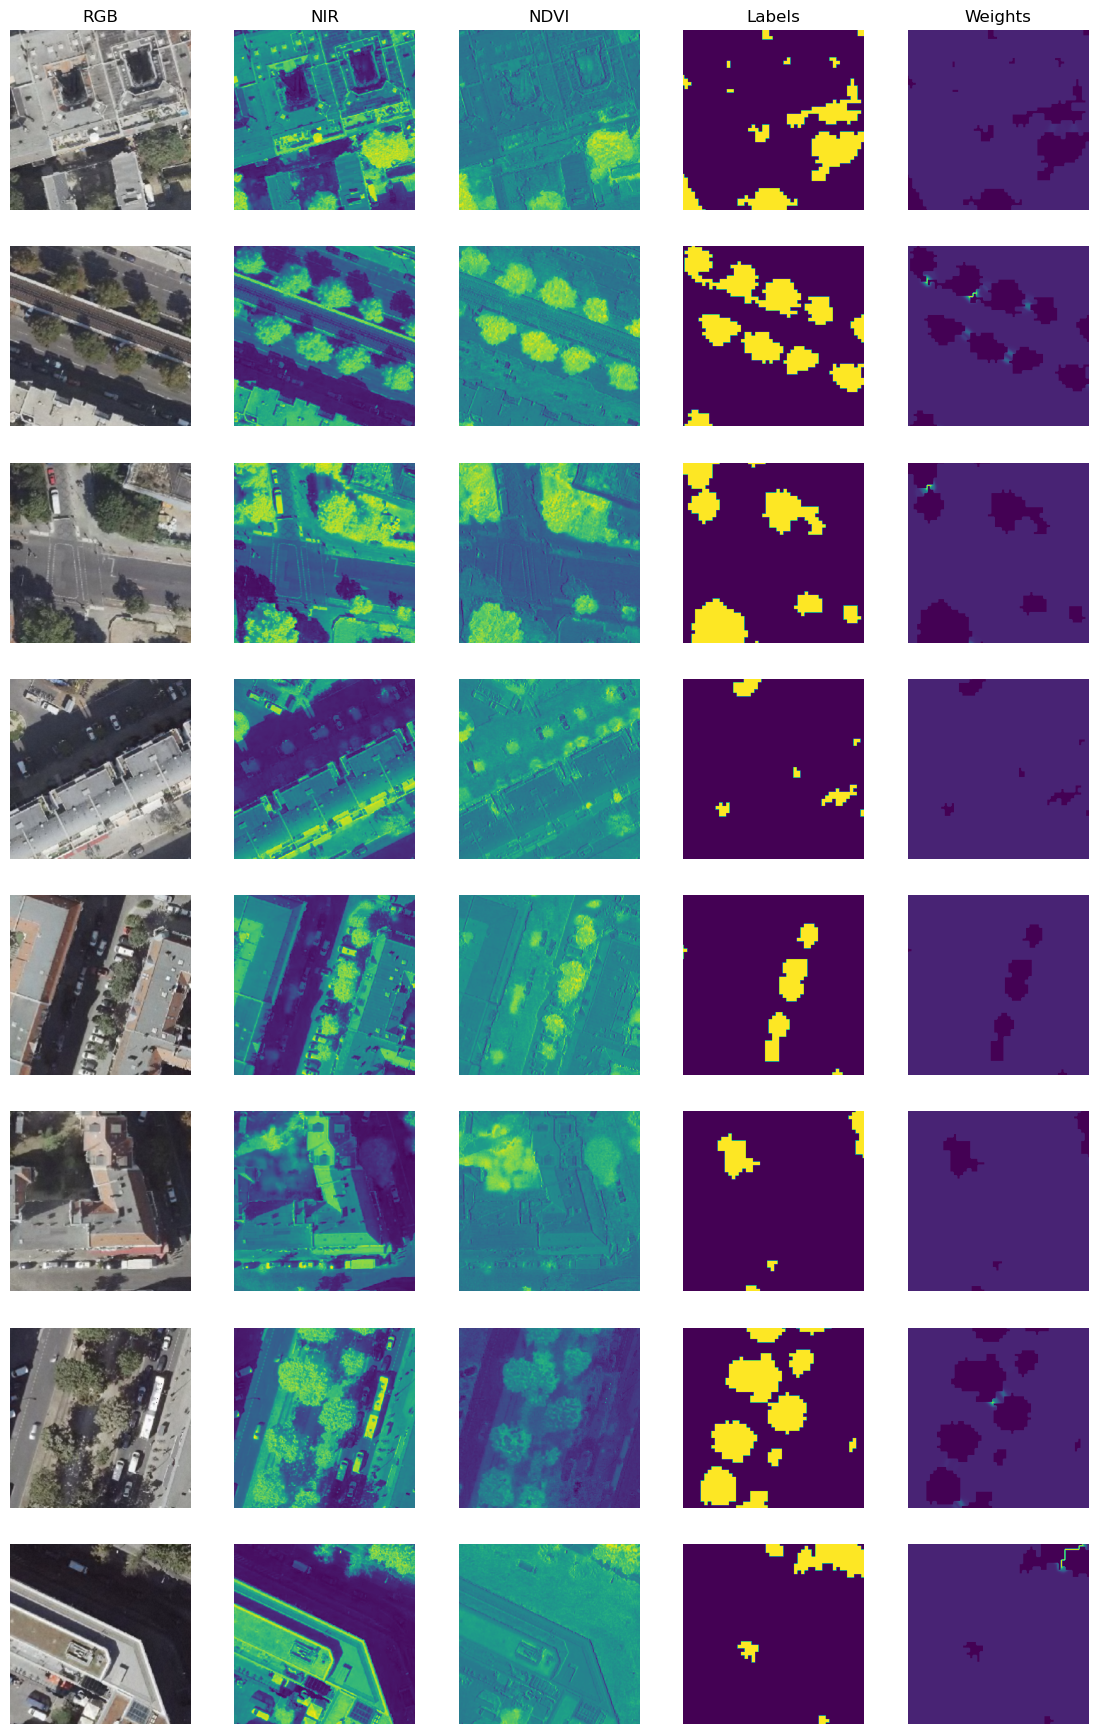

In [5]:
titles = ["RGB", "NIR", "NDVI", "Labels", "Weights"]

train_images, real_label = next(train_generator)
display_images(
    np.concatenate((train_images, real_label), axis=-1),
    config.input_image_channels,
    annotation_channels,
    titles,
)

Define the model and compile it

In [6]:
model = UNet([config.BATCH_SIZE, *config.input_shape], config.input_label_channel)
model.compile(optimizer=config.optimizer, loss=config.loss, metrics=config.metrics)

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  2944        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                              

Train the model

In [ ]:
loss_history = [
    model.fit(
        train_generator,
        steps_per_epoch=config.MAX_TRAIN_STEPS,
        epochs=config.EPOCHS,
        validation_data=val_generator,
        validation_steps=config.VAL_LIMIT,
        callbacks=config.callbacks,
        workers=1
    )
]

Epoch 1/50


2023-02-01 13:36:26.895462: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-01 13:36:27.247368: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-01 13:36:30.688494: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f307dc09a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-01 13:36:30.688511: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-02-01 13:36:30.691439: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-01 13:36:30.735719: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-01 13:36:30.758613: I tensorflow/compiler/jit/xla_compilation_cache

1000/1000 [==============================] - ETA: 0s - loss: 0.5532 - dice_coef: 0.7477 - dice_loss: 0.2523 - specificity: 0.9714 - sensitivity: 0.5373 - accuracy: 0.8816
Epoch 1: val_loss improved from inf to 0.51807, saving model to ./saved_models/UNet/20230201-1335_AdaDelta_weightmap_tversky_01234_256.h5
1000/1000 [==============================] - 268s 255ms/step - loss: 0.5532 - dice_coef: 0.7477 - dice_loss: 0.2523 - specificity: 0.9714 - sensitivity: 0.5373 - accuracy: 0.8816 - val_loss: 0.5181 - val_dice_coef: 0.8600 - val_dice_loss: 0.1400 - val_specificity: 0.9449 - val_sensitivity: 0.6626 - val_accuracy: 0.8815
Epoch 2/50
1000/1000 [==============================] - ETA: 0s - loss: 0.5283 - dice_coef: 0.8732 - dice_loss: 0.1268 - specificity: 0.9748 - sensitivity: 0.5568 - accuracy: 0.8879
Epoch 2: val_loss did not improve from 0.51807
1000/1000 [==============================] - 256s 256ms/step - loss: 0.5283 - dice_coef: 0.8732 - dice_loss: 0.1268 - specificity: 0.9748 - s

Load the model and test

In [9]:
# Load model after training
# If you load a model with different python version, than you may run into a problem: https://github.com/keras-team/keras/issues/9595#issue-303471777

model = tf.keras.models.load_model(
    config.model_fn,
    custom_objects={
        "tversky": config.loss,
        "dice_coef": config.metrics[0],
        "dice_loss": config.metrics[1],
        "accuracy": config.metrics[4],
        "specificity": config.metrics[2],
        "sensitivity": config.metrics[3],
    },
    compile=False,
)

# In case you want to use multiple GPU you can uncomment the following lines.
# from tensorflow.python.keras.utils import multi_gpu_model
# model = multi_gpu_model(model, gpus=2, cpu_merge=False)

model.compile(
    optimizer=config.optimizer,
    loss=config.loss,
    metrics=config.metrics,
)

1/1 [==============================] - 0s 17ms/step
(8, 256, 256, 7)


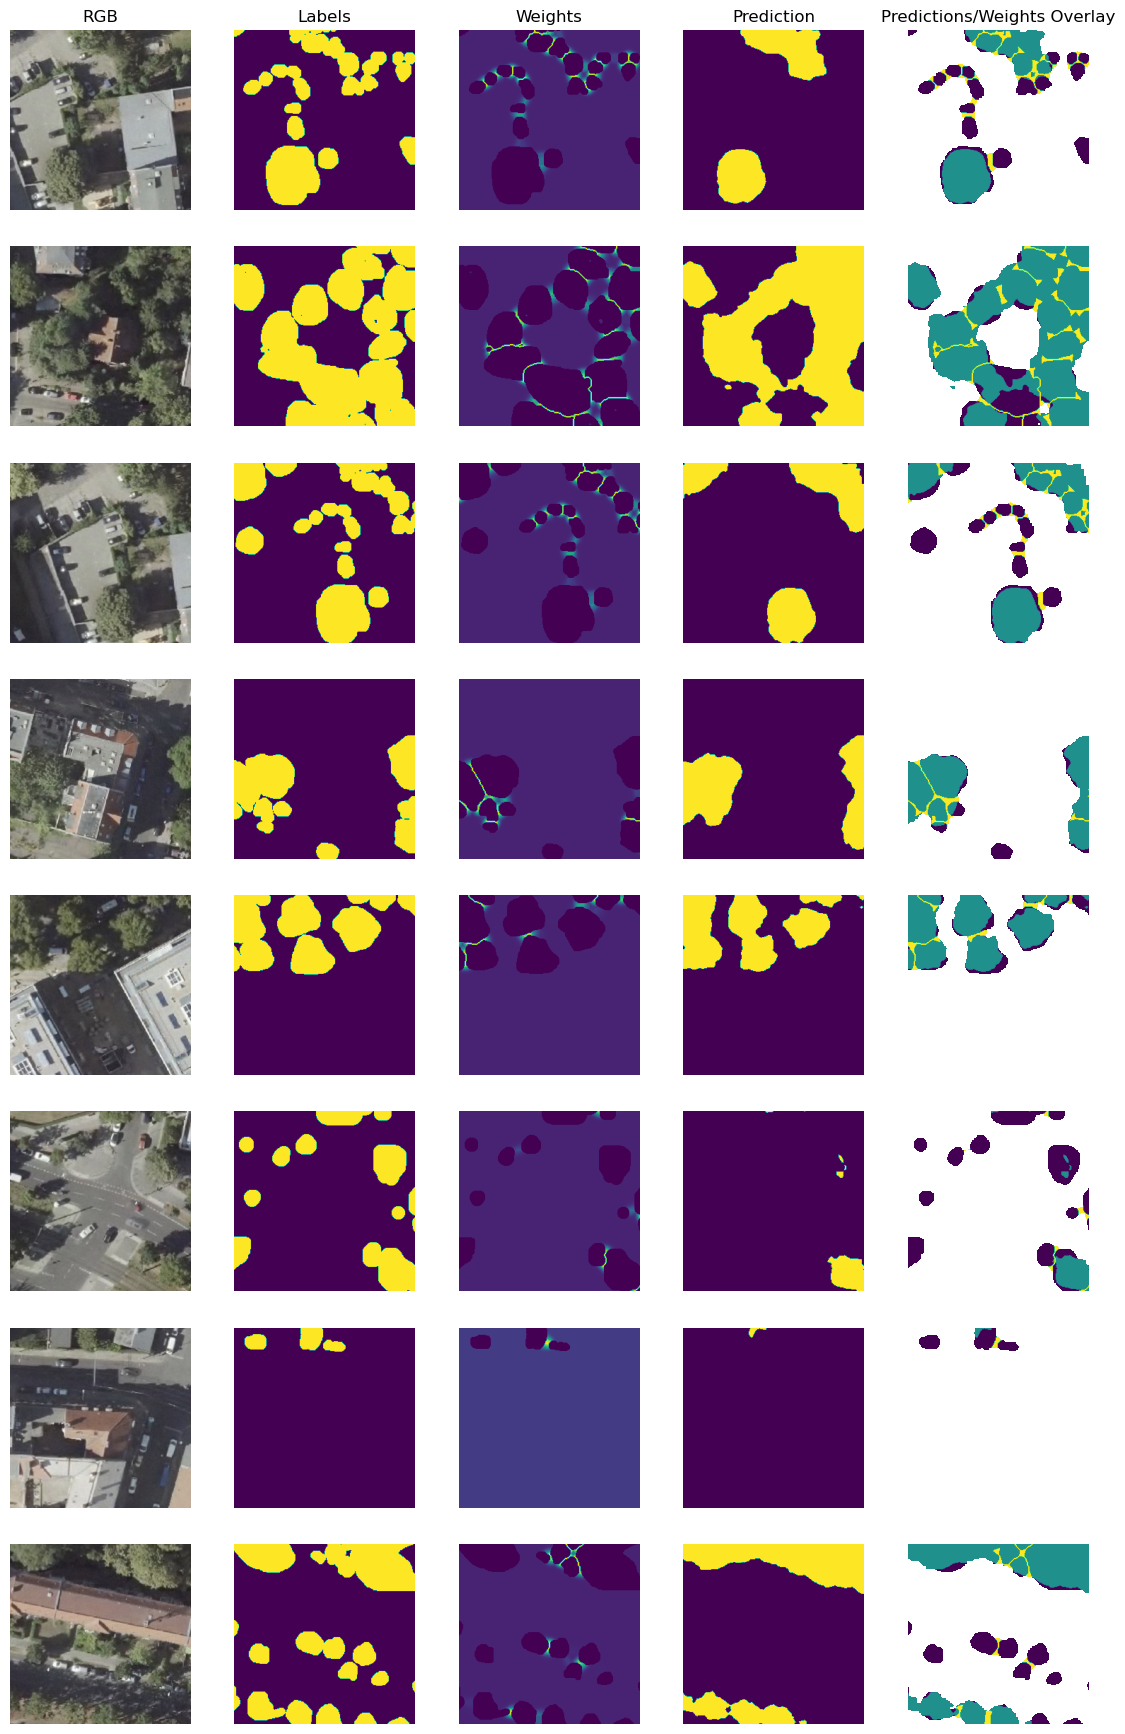

In [140]:
# Print one batch on the training/test data!

titles = ["RGB", "Labels", "Weights", "Prediction", "Predictions/Weights Overlay"]
for i in range(1):
    test_images, real_label = next(test_generator)
    # 5 images per row: RGB, label, weight, prediction + weight overlay
    prediction = model.predict(test_images, steps=1)
    # prediction[prediction > 0.5] = 1
    # prediction[prediction <= 0.5] = 0
    
    weights = np.expand_dims(real_label[..., 1].copy(), -1)
    labels = np.expand_dims(real_label[..., 0].copy(), -1)
    weights[weights > 2] = 10 # boundaries
    weights[weights <= 2] = 0 # background
    # weights[weights == 1] = 3  # background
    # weights[weights == 0] = 1  # labels
    prediction[prediction >= 0.5] = 1  # predictions
    prediction[prediction < 0.5] =  0  # background
    # overlay = weights + (prediction * 15)
    overlay = weights + prediction + labels
    overlay[labels == 1] = 1
    overlay[prediction == 1] = 3
    overlay[weights == 10] = 5
    overlay[(labels == 0) & (prediction == 0) & (weights == 0)] = np.nan
    # overlay[overlay == 1] = np.nan
    
    display_images(
        np.concatenate((test_images[..., [0, 1, 2]], real_label, prediction, overlay), axis=-1),
        config.input_image_channels,
        annotation_channels,
        titles=titles
    )

In [157]:
tp.numpy()

2525.5159

TP: tf.Tensor(10515.0, shape=(), dtype=float32)
FP: tf.Tensor(3672.6, shape=(), dtype=float32)
FN: tf.Tensor(4901.6, shape=(), dtype=float32)
Score: tf.Tensor(0.5508351, shape=(), dtype=float32)


Text(0.5, 1.0, 'Labels')

(-0.5, 255.5, 255.5, -0.5)

(-0.5, 255.5, 255.5, -0.5)

Text(0.5, 1.0, 'Weights')

(-0.5, 255.5, 255.5, -0.5)

Text(0.5, 1.0, 'Pred')

Text(0.5, 1.0, 'TP: 10515.00')

(-0.5, 255.5, 255.5, -0.5)

Text(0.5, 1.0, 'FP: 3672.60')

(-0.5, 255.5, 255.5, -0.5)

Text(0.5, 1.0, 'FN: 4901.60')

(-0.5, 255.5, 255.5, -0.5)

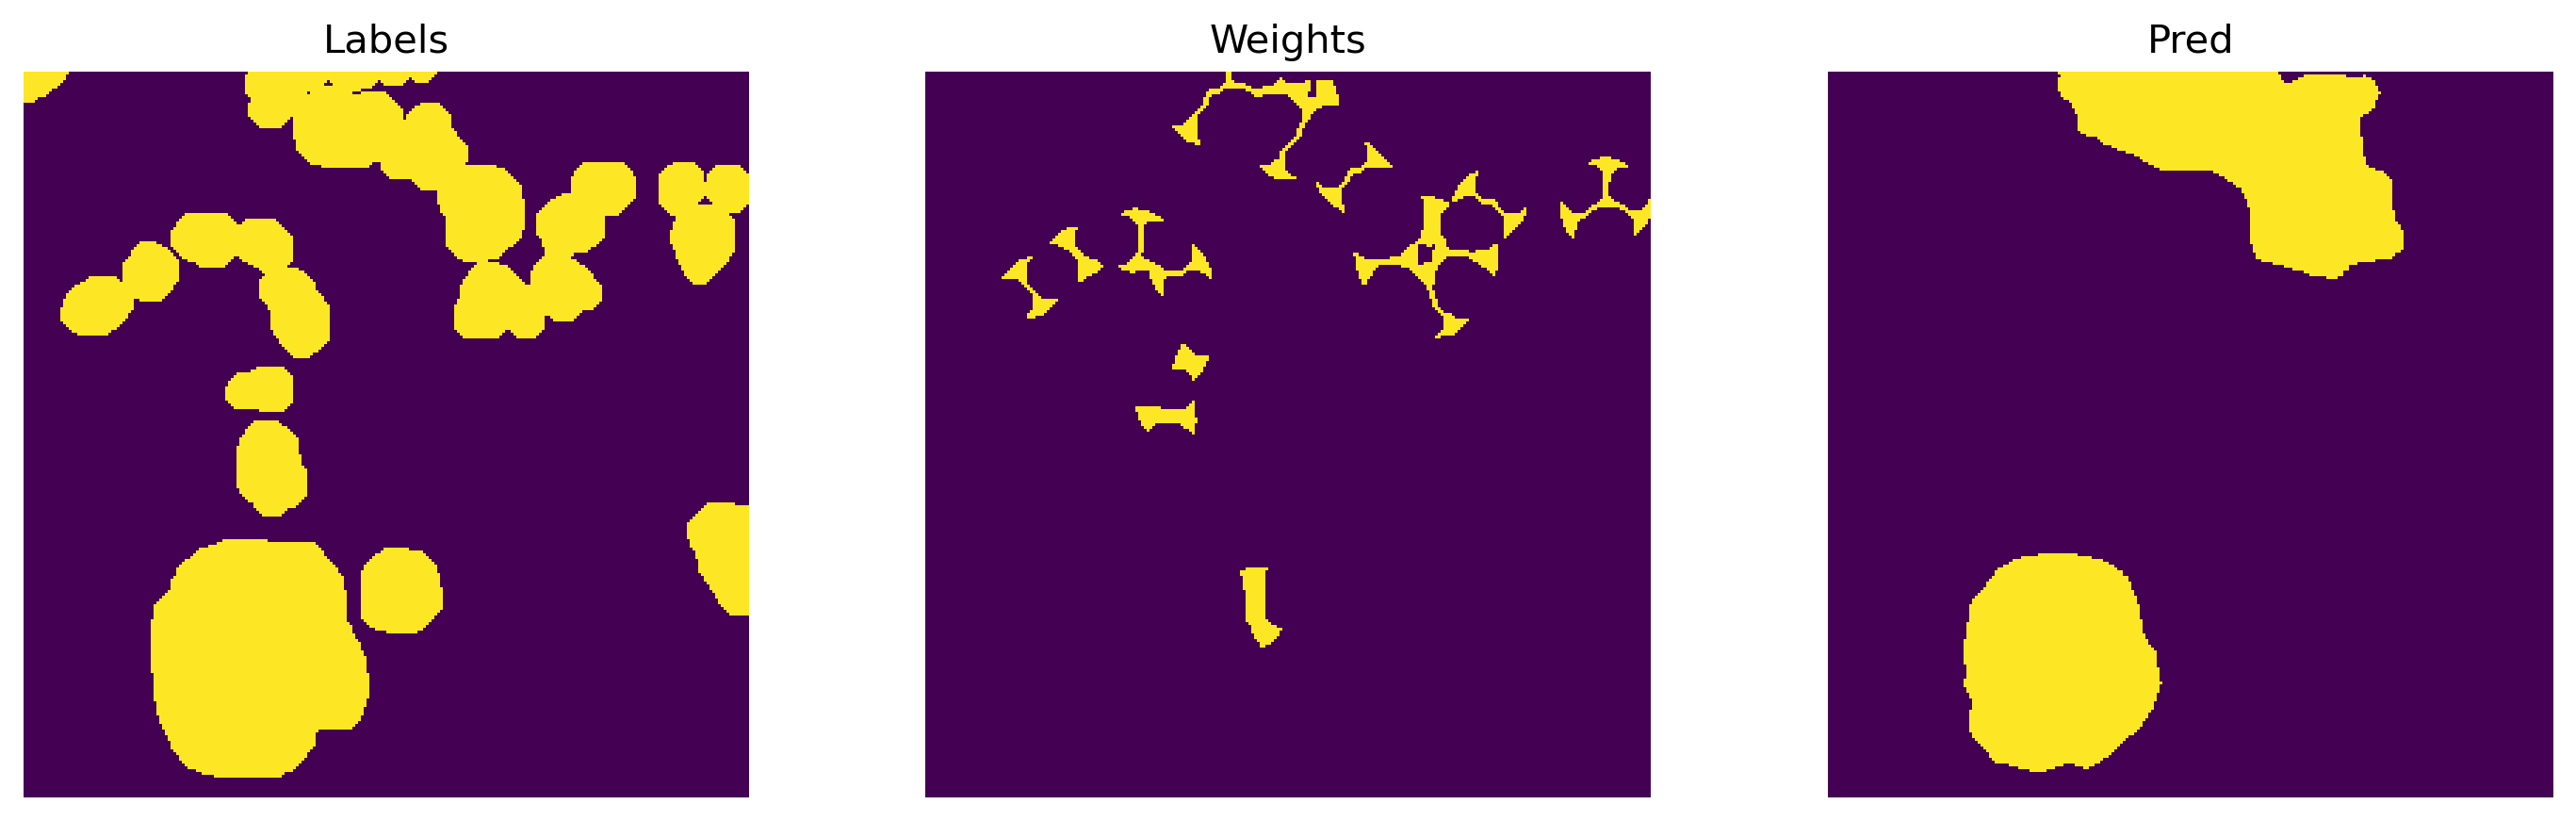

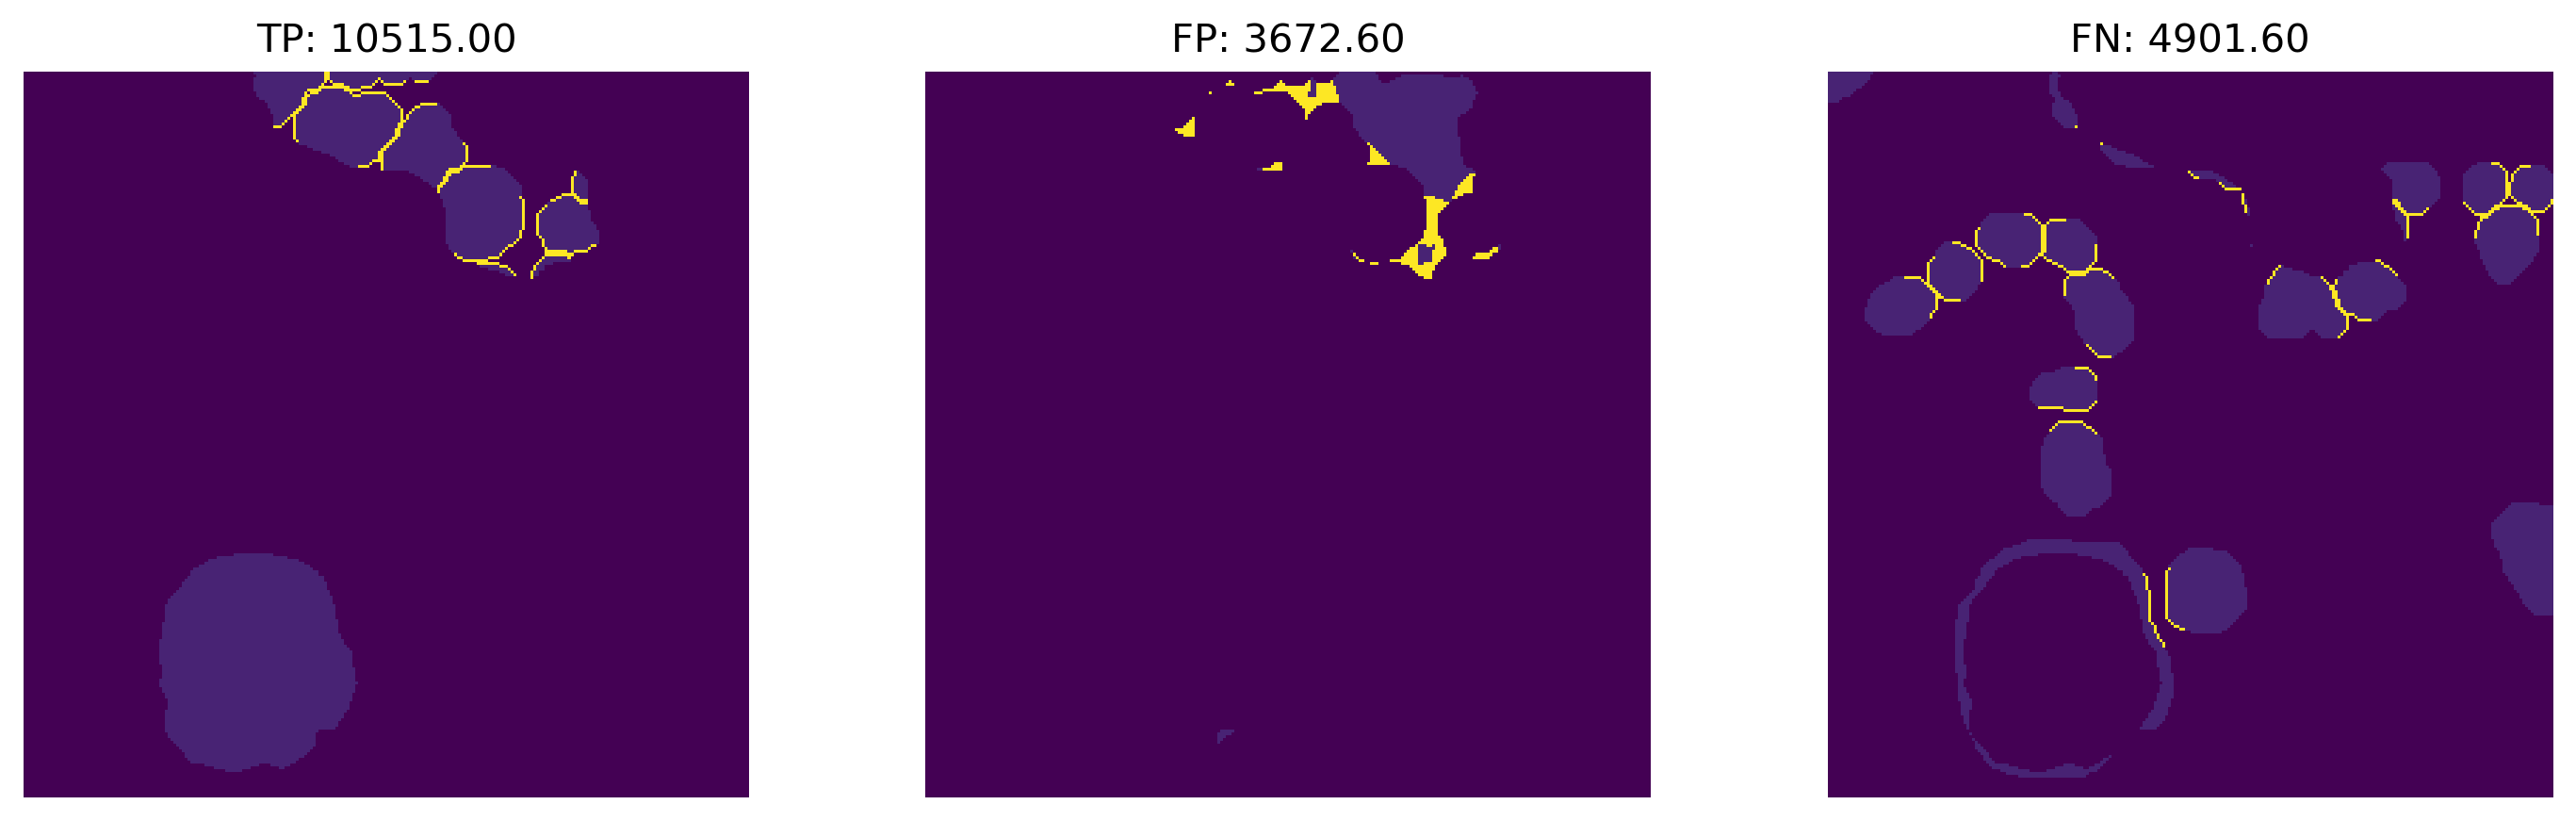

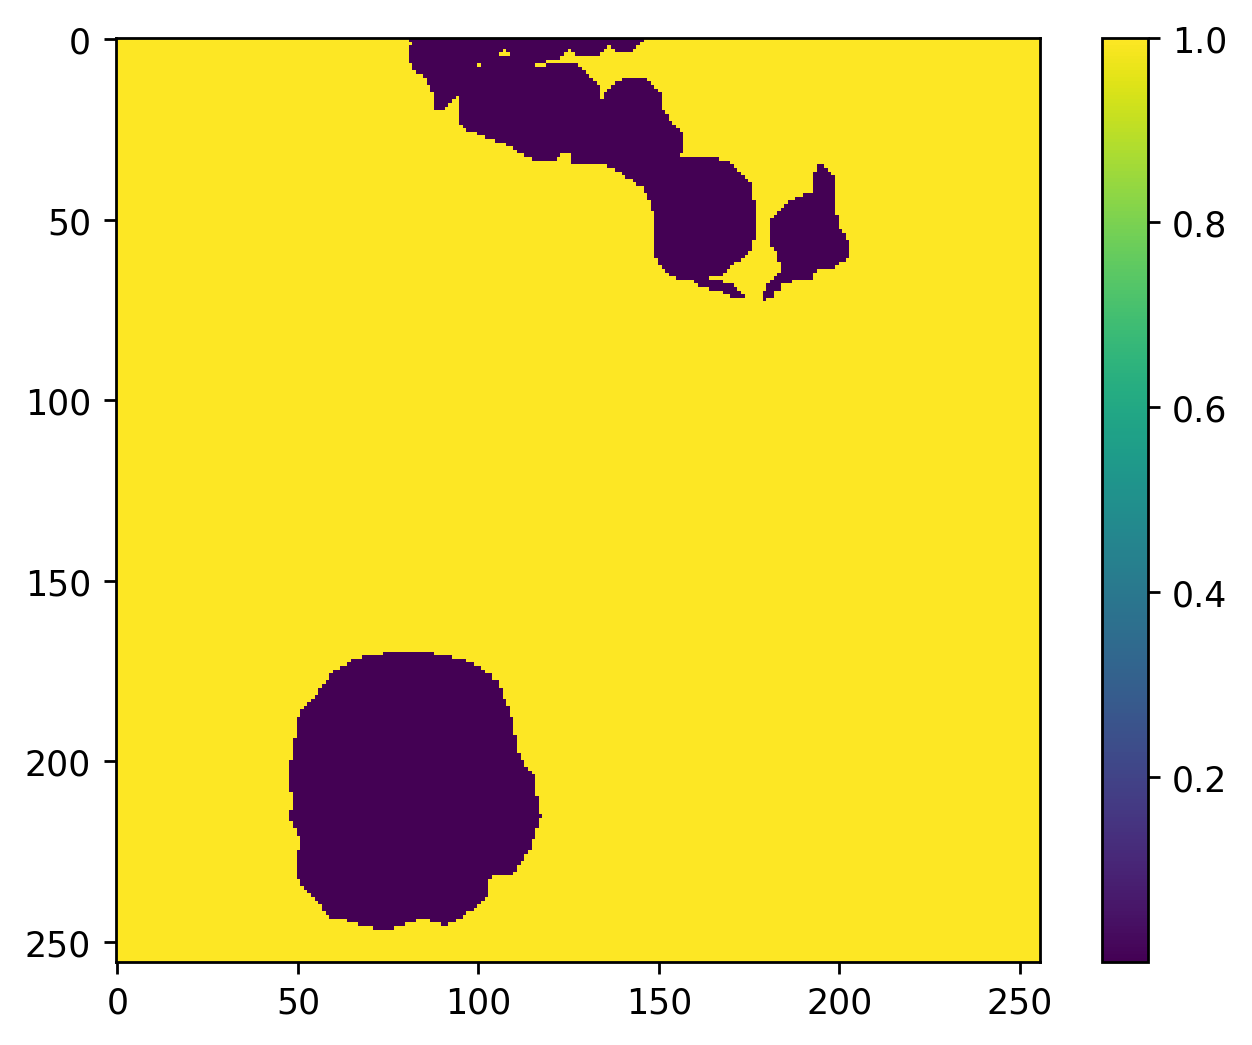

In [179]:
y_pred = prediction[0]
y_t = tf.expand_dims(real_label[0][..., 0].copy(), -1)
y_weights = tf.expand_dims(real_label[0][..., 1].copy(), -1)
alpha = 0.6
beta = 0.4

#### Override weight values to explore effect on losses
y_weights = y_weights.numpy()
y_weights[y_weights >= 2] = 10
y_weights[y_weights < 2] = 1
y_weights = tf.convert_to_tensor(y_weights)

ones = 1
p0 = y_pred  # Probability that pixels are class i
p1 = ones - y_pred  # Probability that pixels are not class i
g0 = y_t  # Ground truth
g1 = ones - y_t

tp_mat = (y_weights * p0 * g0).numpy()
tp = tf.reduce_sum(y_weights * p0 * g0)
fp_mat = (alpha * y_weights * p0 * g1).numpy()
fp = alpha * tf.reduce_sum(y_weights * p0 * g1)
fn_mat = (beta * y_weights * p1 * g0).numpy()
fn = beta * tf.reduce_sum(y_weights * p1 * g0)

EPSILON = 0.00001
numerator = tp
denominator = tp + fp + fn + EPSILON
score = numerator / denominator

score_mat = tp_mat / (tp_mat + fp_mat + fn_mat + EPSILON)

print("TP:", tp)
print("FP:", fp)
print("FN:", fn)
print("Score:", score)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(14, 4), dpi=250)
ax0.imshow(y_t)
ax0.set_title("Labels")
ax0.axis("off")

ax1.imshow(y_weights)
ax1.axis("off")
ax1.set_title("Weights")

ax2.imshow(y_pred)
ax2.axis("off")
ax2.set_title("Pred")

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(14, 4), dpi=250)

ax0.imshow(tp_mat)
ax0.set_title(f"TP: {tp.numpy():.2f}")
ax0.axis("off")

ax1.imshow(fp_mat)
ax1.set_title(f"FP: {fp.numpy():.2f}")
ax1.axis("off")

ax2.imshow(fn_mat)
ax2.set_title(f"FN: {fn.numpy():.2f}")
ax2.axis("off")
# fig.suptitle(f"Score: {score.numpy():.4f}", fontsize=20, y=1.1)
plt.show();

_, ax = plt.subplots(1, 1, dpi=250)
im = ax.imshow(1 - score_mat)
plt.colorbar(im, ax=ax)